Epoch     0 | total=7.2408e+05 | PDE=1.6010e+06, A=0.0000e+00, D=1.0474e-04, C=1.2888e+05, B=3.7636e-13, bottom=1.8196e-13
Epoch   500 | total=1.2288e+02 | PDE=2.8253e+02, A=0.0000e+00, D=1.0336e-07, C=1.8026e-01, B=6.7458e-14, bottom=5.1714e-14
Epoch  1000 | total=3.8143e+01 | PDE=8.7700e+01, A=0.0000e+00, D=7.3524e-08, C=5.7605e-02, B=5.4572e-14, bottom=4.5078e-14
Epoch  1500 | total=1.9981e+01 | PDE=4.5948e+01, A=0.0000e+00, D=7.0221e-08, C=1.4509e-02, B=5.2244e-14, bottom=4.1655e-14
Epoch  2000 | total=1.1336e+01 | PDE=2.6061e+01, A=0.0000e+00, D=1.2031e-07, C=2.5112e-02, B=4.7518e-14, bottom=3.5942e-14
Epoch  2500 | total=4.4343e+00 | PDE=1.0187e+01, A=0.0000e+00, D=2.0295e-07, C=2.3233e-02, B=4.7096e-14, bottom=3.4318e-14
Epoch  3000 | total=9.0985e+01 | PDE=2.0906e+02, A=0.0000e+00, D=1.8051e-07, C=4.1863e-01, B=4.3986e-14, bottom=3.4736e-14
Epoch  3500 | total=2.9971e+00 | PDE=6.8754e+00, A=0.0000e+00, D=2.5706e-07, C=3.6106e-02, B=3.6625e-14, bottom=2.2287e-14
Epoch  4000 | to

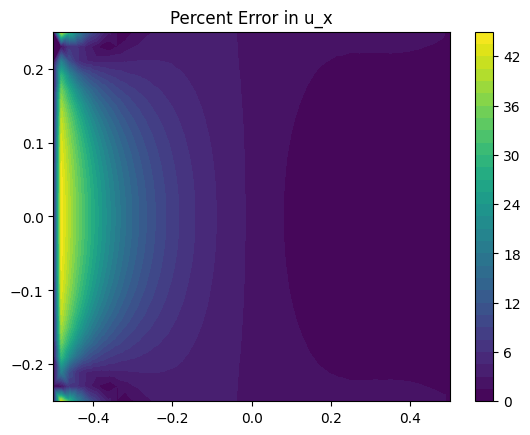

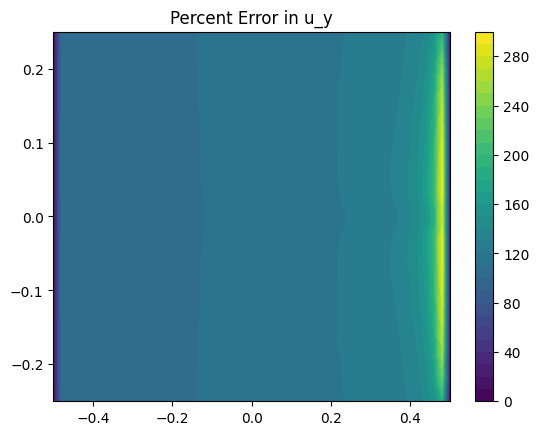

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# Domain & Material Constants
# -----------------------------
L, W = 1.0, 0.5    # domain: x in [-L/2, L/2], y in [-W/2, W/2]
lambda_ = 5.0e9
mu = 5.0e9
h  = 1.0

L_ref = 1.0        # Length scale [m]
u_ref = 1e-6       # Displacement scale [m]
E_ref = 1e9        # Young's modulus scale [Pa]

# -----------------------------
# Weights
# -----------------------------
WEIGHT_B = 1e6         # emphasize top traction-free boundary
WEIGHT_C = 1e6
# emphasize bottom traction-free boundary

# -----------------------------
# 1) PINN Model
# -----------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 2)
        )

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)  # shape (N,2)
        raw = self.net(inputs)            # shape (N,2)

        enforced_out = torch.zeros_like(raw)
        # shape function: zero at x=-0.5
        enforced_out[:, 0] = (x.flatten() + 0.5) * raw[:, 0]  # u_x
        enforced_out[:, 1] = (x.flatten() + 0.5) * raw[:, 1] # * 1e3  # u_y

        # corner constraint example
        corner_mask = (x[:, 0] == 0.5)
        enforced_out[corner_mask, 1] = 0.0

        return enforced_out

# -----------------------------
# 2) Strain & Stress
# -----------------------------
def strain_tensor(u_x, u_y, x, y):
    u_x_x = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                retain_graph=True, create_graph=True)[0]
    u_y_y = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y),
                                retain_graph=True, create_graph=True)[0]
    u_x_y = torch.autograd.grad(u_x, y, grad_outputs=torch.ones_like(u_x),
                                retain_graph=True, create_graph=True)[0]
    u_y_x = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_y),
                                retain_graph=True, create_graph=True)[0]
    E_xx = u_x_x
    E_yy = u_y_y
    E_xy = 0.5 * (u_x_y + u_y_x)
    return E_xx, E_yy, E_xy

def stress_tensor(E_xx, E_yy, E_xy):
    scale_factor = 1e9
    trace_E = E_xx + E_yy
    sigma_xx = h * ((lambda_/scale_factor)*trace_E + 2*(mu/scale_factor)*E_xx)
    sigma_yy = h * ((lambda_/scale_factor)*trace_E + 2*(mu/scale_factor)*E_yy)
    sigma_xy = h * (2*(mu/scale_factor)*E_xy)
    return sigma_xx, sigma_yy, sigma_xy

# -----------------------------
# 3) PDE with Weighted Residual
# -----------------------------
def pde_loss_vectorized(model, x, y):
    """
    Weighted PDE:
      res_x = sigma_xx_x + sigma_xy_y
      res_y = sigma_yy_y + sigma_xy_x
    => res_x^2 + WEIGHT_UY_PDE * (res_y^2).
    """
    x_ = x.clone().detach().requires_grad_(True)
    y_ = y.clone().detach().requires_grad_(True)

    u = model(x_, y_)
    u_x = u[:, 0:1]
    u_y = u[:, 1:2]

    E_xx, E_yy, E_xy = strain_tensor(u_x, u_y, x_, y_)
    sigma_xx, sigma_yy, sigma_xy = stress_tensor(E_xx, E_yy, E_xy)

    sigma_xx_x = torch.autograd.grad(sigma_xx, x_,
                                     grad_outputs=torch.ones_like(sigma_xx),
                                     retain_graph=True,
                                     create_graph=True)[0]
    sigma_xy_y = torch.autograd.grad(sigma_xy, y_,
                                     grad_outputs=torch.ones_like(sigma_xy),
                                     retain_graph=True,
                                     create_graph=True)[0]
    sigma_yy_y = torch.autograd.grad(sigma_yy, y_,
                                     grad_outputs=torch.ones_like(sigma_yy),
                                     retain_graph=True,
                                     create_graph=True)[0]
    sigma_xy_x = torch.autograd.grad(sigma_xy, x_,
                                     grad_outputs=torch.ones_like(sigma_xy),
                                     retain_graph=True,
                                     create_graph=True)[0]

    #res_x = sigma_xx_x + sigma_xy_y
    #res_y = sigma_yy_y + sigma_xy_x

    res_x = (sigma_xx_x + sigma_xy_y) * 1e3 #* (L_ref / (E_ref * u_ref))
    res_y = (sigma_yy_y + sigma_xy_x) * 1e3 # * (L_ref / (E_ref * u_ref))

    return (res_x**2 + res_y**2).flatten()

# -----------------------------
# 4) Boundary Losses
# -----------------------------
def boundary_A_loss_vectorized(model, x, y):
    # x=-L/2 => (u_x=0,u_y=0)
    u = model(x, y)
    return torch.sum(u**2 * 1e8, dim=1)

def boundary_D_loss_vectorized(model, x, y, L):
    # x=+L/2 => (u_x=0.025L, u_y=0)
    u = model(x, y)
    diff_x = u[:,0] - 0.025*L
    diff_y = u[:,1]
    return diff_x**2 + diff_y**2 * 1e8

def boundary_C_loss_vectorized(model, x, y):
    """
    y=0 => (u_y=0) in your original code, but let's keep that if you want it
    This is not the bottom boundary, it's the 'middle' line at y=0.
    (We'll separately handle traction-free at y=-W/2 below.)
    """
    u = model(x, y)
    #return (u[:,1])**2 * 1e8
    return (u[:, 1].flatten())**2 * 1e8

def boundary_B_loss_vectorized(model, x, y, weight_boundaryB=1.0):
    """
    y=+W/2 => traction-free => sigma_yy=0,sigma_xy=0
    => scale by weight_boundaryB, then also /1e18 as in your original code
    """
    x_ = x.clone().detach().requires_grad_(True)
    y_ = y.clone().detach().requires_grad_(True)
    u = model(x_, y_)
    u_x = u[:, 0:1]
    u_y = u[:, 1:2]

    E_xx_B, E_yy_B, E_xy_B = strain_tensor(u_x, u_y, x_, y_)
    sigma_xx_B, sigma_yy_B, sigma_xy_B = stress_tensor(E_xx_B, E_yy_B, E_xy_B)
    # traction-free => (sigma_yy^2 + sigma_xy^2)
    # multiply by weight_boundaryB and also /1e18
    return weight_boundaryB * (sigma_yy_B**2 + sigma_xy_B**2).flatten() / 1e18

def boundary_bottom_loss_vectorized(model, x, y, weight_boundaryC=1.0):
    """
    y=-W/2 => traction-free => sigma_yy=0, sigma_xy=0
    => scale by weight_boundaryC
    """
    x_ = x.clone().detach().requires_grad_(True)
    y_ = y.clone().detach().requires_grad_(True)
    u = model(x_, y_)
    u_x, u_y = u[:, 0:1], u[:, 1:2]

    E_xx_C, E_yy_C, E_xy_C = strain_tensor(u_x, u_y, x_, y_)
    sigma_xx_C, sigma_yy_C, sigma_xy_C = stress_tensor(E_xx_C, E_yy_C, E_xy_C)
    return weight_boundaryC * (sigma_yy_C**2 + sigma_xy_C**2).flatten() / 1e18

# -----------------------------
# 5) Combined Vectorized Loss
# -----------------------------
def combined_loss_vectorized(model, x, y, L, W, tol=1e-6):
    """
    PDE (top half) + boundaries A, D, C(y=0) + B(y=+W/2), 
    plus bottom traction-free at y=-W/2 (call boundary_bottom_loss_vectorized).
    Then we combine them in one big batch with masks.
    We'll up-weight B and bottom traction with WEIGHT_B, WEIGHT_C.
    """
    xf = x.flatten()
    yf = y.flatten()

    # left boundary
    maskA = torch.isclose(xf, torch.tensor(-L/2, device=xf.device), atol=tol)
    # right boundary
    maskD = torch.isclose(xf, torch.tensor(+L/2, device=xf.device), atol=tol)
    # middle line
    maskC = torch.isclose(yf, torch.tensor(0.0, device=yf.device), atol=tol)
    # top boundary
    maskB = torch.isclose(yf, torch.tensor(+W/2, device=yf.device), atol=tol)
    # bottom boundary
    mask_bottom = torch.isclose(yf, torch.tensor(-W/2, device=yf.device), atol=tol)

    # PDE domain => y in [0,W/2], excluding boundary lines
    mask_pde = ~(maskA | maskD | maskC | maskB | mask_bottom) & (yf >= 0) & (yf <= W/2)

    N = x.shape[0]
    pointwise_loss = torch.zeros(N, dtype=torch.float32, device=x.device)
    sub_losses = {'pde': 0.0, 'A': 0.0, 'D': 0.0, 'C': 0.0, 'B': 0.0, 'bottom': 0.0}

    # PDE
    if mask_pde.any():
        xp = x[mask_pde].view(-1,1)
        yp = y[mask_pde].view(-1,1)
        pde_vals = pde_loss_vectorized(model, xp, yp)
        pointwise_loss[mask_pde] = pde_vals
        sub_losses['pde'] = float(torch.mean(pde_vals))

    # boundary A
    if maskA.any():
        xA = x[maskA].view(-1,1)
        yA = y[maskA].view(-1,1)
        valsA = boundary_A_loss_vectorized(model, xA, yA)
        pointwise_loss[maskA] = valsA
        sub_losses['A'] = float(torch.mean(valsA))

    # boundary D
    if maskD.any():
        xD = x[maskD].view(-1,1)
        yD = y[maskD].view(-1,1)
        valsD = boundary_D_loss_vectorized(model, xD, yD, L)
        pointwise_loss[maskD] = valsD
        sub_losses['D'] = float(torch.mean(valsD))

    # boundary C (the line y=0)
    if maskC.any():
        xC = x[maskC].view(-1,1)
        yC = y[maskC].view(-1,1)
        valsC = boundary_C_loss_vectorized(model, xC, yC)
        pointwise_loss[maskC] = valsC
        sub_losses['C'] = float(torch.mean(valsC))

    # boundary B (top)
    if maskB.any():
        xB = x[maskB].view(-1,1)
        yB = y[maskB].view(-1,1)
        valsB = boundary_B_loss_vectorized(model, xB, yB, weight_boundaryB=WEIGHT_B)
        pointwise_loss[maskB] = valsB
        sub_losses['B'] = float(torch.mean(valsB))

    # bottom boundary => traction-free
    if mask_bottom.any():
        x_bot = x[mask_bottom].view(-1,1)
        y_bot = y[mask_bottom].view(-1,1)
        valsBot = boundary_bottom_loss_vectorized(model, x_bot, y_bot, weight_boundaryC=WEIGHT_C)
        pointwise_loss[mask_bottom] = valsBot
        sub_losses['bottom'] = float(torch.mean(valsBot))

    total_loss = torch.mean(pointwise_loss)
    return total_loss, sub_losses


def train_pinn_vectorized(model, optimizer, n_epochs, n_points, L, W):
    loss_history = []
    for epoch in range(n_epochs):
        # PDE points in the entire domain or top half:
        x_in = (torch.rand((n_points,1)) * L) - (L/2)
        # y_in = (torch.rand((n_points,1)) * (W)) - (W/2)  # sample entire domain
        y_in = (torch.rand((n_points,1)) * (W/2))
        # You might do y_in in [0,W/2], but let's do full domain so PDE is enforced below too.

        # boundary sets
        yA = torch.linspace(-W/2, W/2, 100).reshape(-1,1)
        xA = -L/2 * torch.ones_like(yA)
        yD = torch.linspace(-W/2, W/2, 100).reshape(-1,1)
        xD =  L/2 * torch.ones_like(yD)
        xC = torch.linspace(-L/2, L/2, 500).reshape(-1,1)
        yC = torch.zeros_like(xC)
        xB = torch.linspace(-L/2, L/2, 100).reshape(-1,1)
        yB = (W/2)*torch.ones_like(xB)
        xBot = torch.linspace(-L/2, L/2, 500).reshape(-1,1)
        yBot = -(W/2) * torch.ones_like(xBot)

        # Combine
        all_x = torch.cat([x_in, xA, xD, xC, xB, xBot], dim=0)
        all_y = torch.cat([y_in, yA, yD, yC, yB, yBot], dim=0)

        total_loss, sub_dict = combined_loss_vectorized(model, all_x, all_y, L, W, tol=1e-6)
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        loss_history.append(total_loss.item())

        if epoch % 500 == 0:
            print(
                f"Epoch {epoch:5d} | total={total_loss.item():.4e} "
                f"| PDE={sub_dict['pde']:.4e}, A={sub_dict['A']:.4e}, "
                f"D={sub_dict['D']:.4e}, C={sub_dict['C']:.4e}, "
                f"B={sub_dict['B']:.4e}, bottom={sub_dict['bottom']:.4e}"
            )

    return loss_history


model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

n_epochs = 10000
n_points = 1000
loss_history = train_pinn_vectorized(model, optimizer, n_epochs, n_points, L, W)


file_path = '/Users/murat/Downloads/data.csv'
comparison_data = pd.read_csv(file_path)

x_vals = torch.tensor(comparison_data['X'].values, dtype=torch.float32).reshape(-1,1)
y_vals = torch.tensor(comparison_data['Y'].values, dtype=torch.float32).reshape(-1,1)
u_x_actual = comparison_data['u_x_actual'].values
u_y_actual = comparison_data['u_y_actual'].values

# If you do reflection for negative y
model.eval()
with torch.no_grad():
    # Possibly reflect y-values
    y_abs = y_vals.abs()
    u_pred_top = model(x_vals, y_abs)

u_pred = u_pred_top.clone()
u_pred[:, 1]  # Rescale uY
mask_bottom = (y_vals < 0).view(-1)
u_pred[mask_bottom, 1] *= -1.0

u_x_pred = u_pred[:, 0].numpy()
u_y_pred = u_pred[:, 1].numpy()

comparison_data['u_x_pred'] = u_x_pred
comparison_data['u_y_pred'] = u_y_pred

comparison_data['error_u_x'] = abs(u_x_actual - u_x_pred)
comparison_data['error_u_y'] = abs(u_y_actual - u_y_pred)

def safe_percent_error(a, p):
    if np.isclose(a, 0.0):
        return 0.0
    else:
        return abs(a - p) / abs(a) * 100.0

comparison_data['percent_error_u_x'] = [
    safe_percent_error(a, p) for a, p in zip(u_x_actual, u_x_pred)
]
comparison_data['percent_error_u_y'] = [
    safe_percent_error(a, p) for a, p in zip(u_y_actual, u_y_pred)
]

avg_percent_error_x = comparison_data['percent_error_u_x'].mean()
avg_percent_error_y = comparison_data['percent_error_u_y'].mean()

print(comparison_data)
print(f"Average Percent Error for u_x: {avg_percent_error_x:.2f}%")
print(f"Average Percent Error for u_y: {avg_percent_error_y:.2f}%")

# -----------------------------
# 2D Plot of Errors
# -----------------------------
X = comparison_data['X'].values
Y = comparison_data['Y'].values
err_x = comparison_data['percent_error_u_x'].values
err_y = comparison_data['percent_error_u_y'].values

plt.figure()
plt.tricontourf(X, Y, err_x, levels=30)
plt.colorbar()
plt.title("Percent Error in u_x")

plt.figure()
plt.tricontourf(X, Y, err_y, levels=30)
plt.colorbar()
plt.title("Percent Error in u_y")

plt.show()


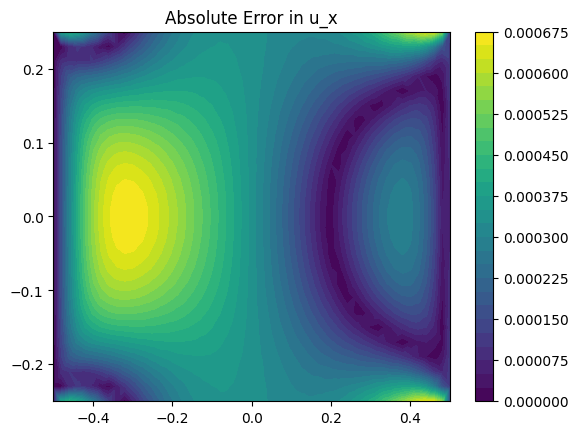

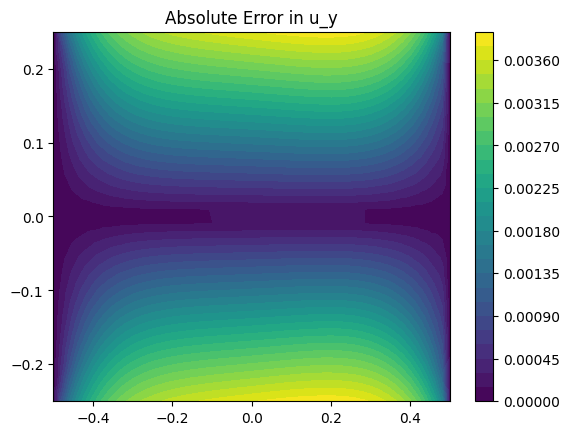

Text(0.5, 1.0, 'Comsol prediction of u_y')

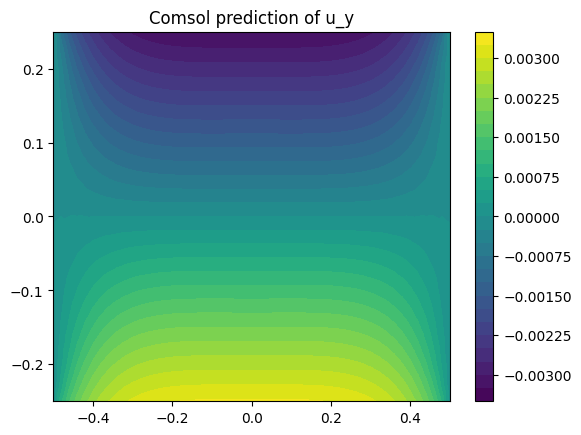

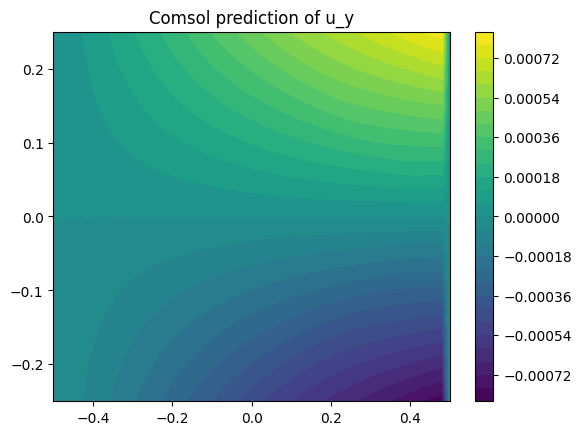

In [3]:
plt.figure()
plt.tricontourf(X, Y, comparison_data['error_u_x'].values, levels=30)
plt.colorbar()
plt.title("Absolute Error in u_x")

plt.figure()
plt.tricontourf(X, Y, comparison_data['error_u_y'].values, levels=30)
plt.colorbar()
plt.title("Absolute Error in u_y")

plt.show()

plt.figure()
plt.tricontourf(X, Y, comparison_data['u_y_actual'].values, levels=30)
plt.colorbar()
plt.title("Comsol prediction of u_y")

plt.figure()
plt.tricontourf(X, Y, comparison_data['u_y_pred'].values, levels=30)
plt.colorbar()
plt.title("Comsol prediction of u_y")


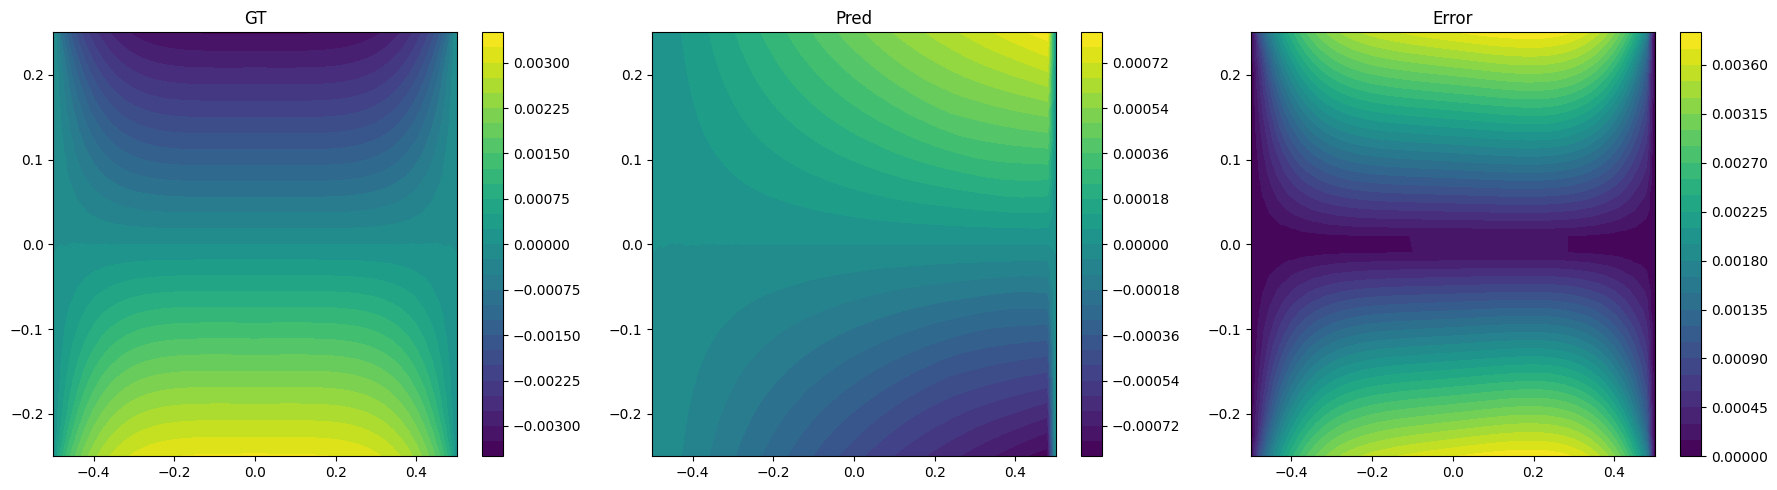

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

contour1 = axs[0].tricontourf(X, Y, u_y_actual, levels=30)
fig.colorbar(contour1, ax=axs[0])
axs[0].set_title("GT")

contour2 = axs[1].tricontourf(X, Y, u_y_pred, levels=30)
fig.colorbar(contour2, ax=axs[1])
axs[1].set_title("Pred")

contour3 = axs[2].tricontourf(X, Y, np.abs(u_y_pred - u_y_actual), levels=30)
fig.colorbar(contour3, ax=axs[2])
axs[2].set_title("Error")

plt.tight_layout()
plt.show()

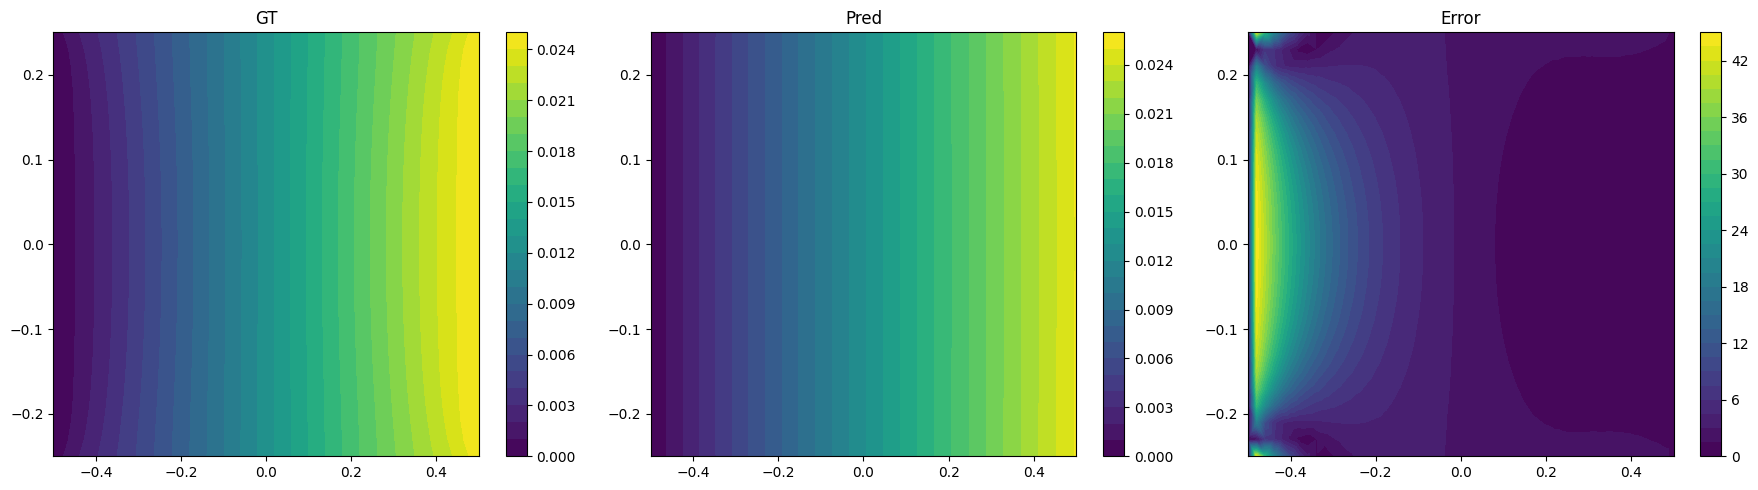

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

contour1 = axs[0].tricontourf(X, Y, u_x_actual, levels=30)
fig.colorbar(contour1, ax=axs[0])
axs[0].set_title("GT")

contour2 = axs[1].tricontourf(X, Y, u_x_pred, levels=30)
fig.colorbar(contour2, ax=axs[1])
axs[1].set_title("Pred")

contour3 = axs[2].tricontourf(X, Y, err_x, levels=30)
fig.colorbar(contour3, ax=axs[2])
axs[2].set_title("Error")

plt.tight_layout()
plt.show()